In [1]:
!pwd

/home/kimbg/SPN


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID";
os.environ["CUDA_VISIBLE_DEVICES"]="1";

import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import cv2
import tensorflow as tf
import glob

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)

print('tensorflow version :', tf.__version__)
print('TF GPU available test :', tf.test.is_gpu_available())

tensorflow version : 2.1.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TF GPU available test : True


0. 각종 사용자 변수 정의

2. 마스크 확인
3. 마스크를 학습용 마스크로 변환
4. 변환된 마스크 확인
5. 

## 0. 각종 사용자 변수 정의

In [3]:
VOC_COLORMAP = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

## 의문 ##
# 엣지 클래스도 넣어야하는거 아닌가..???

In [4]:
BATCH_SIZE = 8
IMG_SIZE = (256, 256, 3)


image_dataset_path = '/data1/kimbg/voc2012/SegmentationDB/image'
gt_dataset_path = '/data1/kimbg/voc2012/SegmentationClass'

In [5]:
img_dataset_abspath = sorted(glob.glob(os.path.join(image_dataset_path, '*')))
mask_dataset_abspath = sorted(glob.glob(os.path.join(gt_dataset_path, '*')))
print(f'이미지 갯수 : {len(img_dataset_abspath)}')
print(f'마스크 갯수 : {len(mask_dataset_abspath)}')
print(list(map(os.path.basename, img_dataset_abspath))[:3])
print(list(map(os.path.basename, mask_dataset_abspath))[:3])

이미지 갯수 : 2913
마스크 갯수 : 2913
['2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg']
['2007_000032.png', '2007_000033.png', '2007_000039.png']


In [6]:
def img_show(path):
    # img = plt.imread(path)
    # img1 = plt.imshow(img)
    img = cv2.imread(path)
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # 무조건 RGB로 읽어야 VOC_CLASSES랑 매치가 가능함. Image.open으로 파일 열고 np.array화해서 보면 클래스 세부내용 확인가능.
    plt.imshow(img1)
    print(img1.shape)

    
# 채널별로 나눠진 클래스 마스크를 시각화.
def display_multiple_img(mask1, VOC_CLASSES, rows = 1, cols=1):
    figure, ax = plt.subplots(nrows=rows, ncols=cols)
    for label, i in zip(VOC_CLASSES, range(rows*cols)):
#         print(label)
        ax.ravel()[i].imshow(mask1[:,:,i], cmap='gray')
        ax.ravel()[i].set_title(label)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()


# 마스크를 클래스에 맵핑하여 클래스갯수만큼 depth생성
def mk_seg_mask(gt_path, VOC_COLORMAP):
    gt1_cv2 = cv2.imread(gt_path)
    mask = cv2.cvtColor(gt1_cv2, cv2.COLOR_BGR2RGB)
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.float32)
    for label_index, label in enumerate(VOC_COLORMAP):
    #     print(label_index, label)
        segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(float)
    return segmentation_mask


# 학습용 이미지, 마스크 생성(categorical_crossentropy)
def img_mask_set(img_path, mask_path, VOC_COLORMAP):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMG_SIZE[0], IMG_SIZE[1]), cv2.INTER_LINEAR)/255
    img = np.array(img, dtype=np.float32)
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = cv2.resize(mask, (IMG_SIZE[0], IMG_SIZE[1]), cv2.INTER_LINEAR)
    
    height, width = mask.shape[:2]
    segmentation_mask = np.zeros((height, width, len(VOC_COLORMAP)), dtype=np.uint8)
    for label_index, label in enumerate(VOC_COLORMAP):
        segmentation_mask[:, :, label_index] = np.all(mask == label, axis=-1).astype(np.uint8)
    
    mask = np.array(mask/255, dtype=np.float32)
    
    return img, segmentation_mask, mask


# 학습 데이터셋(이미지, 마스크)를 구성
def dataset(img_dataset_abspath, mask_dataset_abspath, start_cnt, BATCH_SIZE):
#     start_cnt = 0

    batch_img = np.empty((BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3))
    batch_seg_mask = np.empty((BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], len(VOC_CLASSES)))
    batch_mask = np.empty((BATCH_SIZE, IMG_SIZE[0], IMG_SIZE[1], 3))

    batch_img_path = img_dataset_abspath[start_cnt:BATCH_SIZE]
    batch_img_path = sorted(glob.glob(os.path.join(img_dataset_abspath, '*')))
#     print(batch_img_path)
#     batch_seg_mask_path = mask_dataset_abspath[start_cnt:BATCH_SIZE]
    batch_seg_mask_path = sorted(glob.glob(os.path.join(mask_dataset_abspath, '*')))

    for bat in range(BATCH_SIZE):
        img_b, seg_mask_b, mask_b = img_mask_set(batch_img_path[bat], batch_seg_mask_path[bat], VOC_COLORMAP)
        batch_img[bat] = img_b
        batch_seg_mask[bat] = seg_mask_b
        batch_mask[bat] = mask_b
        
    return batch_img, batch_seg_mask, batch_mask

## 1. 이미지 확인

In [7]:
DATASET_IMG, DATASET_SEG_MASK, DATASET_MASK = dataset(image_dataset_path, gt_dataset_path, 0, 100)
print(DATASET_IMG.shape, DATASET_SEG_MASK.shape, DATASET_MASK.shape)

(100, 256, 256, 3) (100, 256, 256, 21) (100, 256, 256, 3)


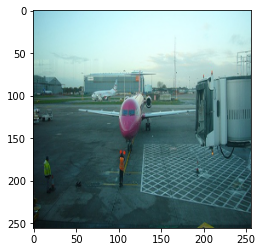

In [8]:
plt.imshow(DATASET_IMG[0])

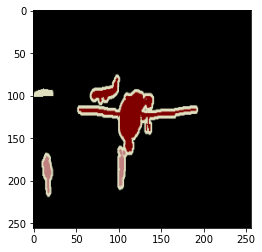

In [9]:
plt.imshow(DATASET_MASK[0])

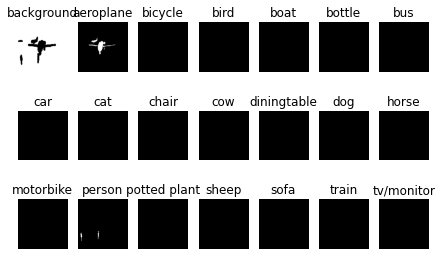

In [10]:
display_multiple_img(DATASET_SEG_MASK[0], VOC_CLASSES, 3, 7)

## 2. 모델 구성

In [11]:
def unet(target_size=(256,256,3)):

    IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = target_size[0], target_size[1], target_size[2]

    #Build the model
    inputs = tf.keras.layers.Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)

    #Contraction path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
    
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    #Expansive path 
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    
    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(21, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    
    outputs = tf.keras.layers.Conv2D(21, (1, 1), activation='softmax')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

    return model
    

In [14]:
model = unet(IMG_SIZE)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 256, 256, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         lambda_1[0][0]                   
__________________________________________________________________________________________________
dropout_9 (Dropout)             (None, 256, 256, 16) 0           conv2d_19[0][0]                  
____________________________________________________________________________________________

In [19]:
model.compile(optimizer='adam', loss="categorical_crossentropy")

weight_path = "/home/kimbg/SPN/Colab Notebooks/MyUnet/weight/model_for_nuclei_2.h5"

callback = [
#              tf.keras.callbacks.EarlyStopping(patience=30, monitor='val_loss'),
#              tf.keras.callbacks.TensorBoard(log_dir='logs'),
             tf.keras.callbacks.ModelCheckpoint(weight_path, verbose=1, save_best_only=True)
             ]

In [20]:
results = model.fit(DATASET_IMG, DATASET_SEG_MASK, 
                    validation_split=0.1, batch_size=3, epochs=500, callbacks=callback)

Train on 90 samples, validate on 10 samples
Epoch 1/500
87/90 [============================>.] - ETA: 0s - loss: 1.1396
Epoch 00001: val_loss improved from inf to 1.20879, saving model to /home/kimbg/SPN/Colab Notebooks/MyUnet/weight/model_for_nuclei_2.h5
90/90 [==============================] - 4s 45ms/sample - loss: 1.1316 - val_loss: 1.2088
Epoch 2/500
87/90 [============================>.] - ETA: 0s - loss: 1.1127
Epoch 00002: val_loss did not improve from 1.20879
90/90 [==============================] - 1s 12ms/sample - loss: 1.1157 - val_loss: 1.2248
Epoch 3/500
84/90 [===========================>..] - ETA: 0s - loss: 1.1372
Epoch 00003: val_loss improved from 1.20879 to 1.20475, saving model to /home/kimbg/SPN/Colab Notebooks/MyUnet/weight/model_for_nuclei_2.h5
90/90 [==============================] - 1s 16ms/sample - loss: 1.1244 - val_loss: 1.2047
Epoch 4/500
84/90 [===========================>..] - ETA: 0s - loss: 1.1077
Epoch 00004: val_loss improved from 1.20475 to 1.19911,

(1, 256, 256, 21)


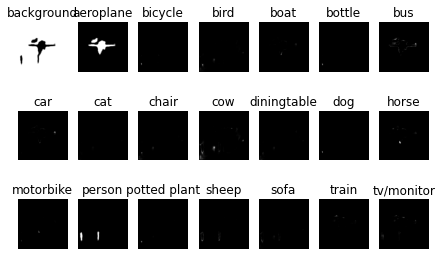

In [21]:
pred = model.predict(DATASET_IMG[:1])
print(pred.shape)
display_multiple_img(pred[0], VOC_CLASSES, 3, 7)

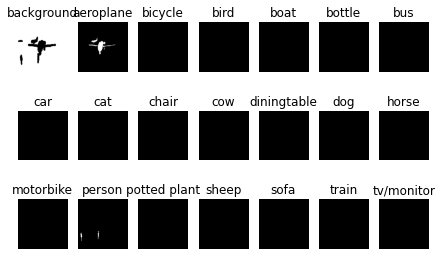

In [22]:
display_multiple_img(DATASET_SEG_MASK[0], VOC_CLASSES, 3, 7)

In [91]:
sample_vec = pred[0][200][220]
print(sample_vec.shape)
print(sample_vec)
np.argmax(sample_vec)


(21,)
[0.5875857  0.0144795  0.01100462 0.01289494 0.00919026 0.006711
 0.03143212 0.01132954 0.02154358 0.01622048 0.02175937 0.03333526
 0.00919544 0.01347379 0.01322803 0.09231371 0.00473944 0.02180125
 0.0179406  0.02653014 0.02329139]


0

In [92]:
np.sum(pred[0][0][0])

0.99999994

In [78]:
sum(pred[0][0][1])

0.9999999328583726

In [79]:
sum(pred[0][0][2])

0.9999999612291504

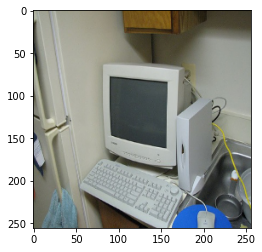

In [96]:
plt.imshow(DATASET_IMG[2])

In [21]:
from tensorflow.keras import layers
from tensorflow import keras
img_size = (256, 256)
num_classes = 21
batch_size = 3
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model

In [21]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________